# Figure 6 A ~ D # R Kernel

In [2]:
suppressMessages(library(cowplot))
suppressMessages(library(patchwork))
suppressMessages(library(ggpubr))
suppressMessages(library(ggplot2))
suppressMessages(library(grid))
suppressMessages(library(gridExtra))
suppressMessages(library(dplyr))
suppressMessages(library(tidyverse))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ggalluvial))

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


##  Figure 6A

In [4]:
# 
DensityPlot <- function(data,title,color_str=c('GF'="#0000ff",'SPF'="#ff0000"),
                       xlim=c(-5,2),x_breaks = 1,
                        ylim=c(0,0.7),y_breaks = 0.2,labels){
    data$group <- factor(data$group,levels = c("GF","SPF"))
    p <-ggplot(data, aes(log10(value+0.00001), fill = group,alpha=0.8)) +
        geom_density() +
      labs(title = title, x = "",y = "") + theme_classic() + 
      theme(plot.title = element_text(size = 25,hjust = 0.5,face = "bold"))+
      theme(axis.text = element_text(size = 20),axis.title = element_text(size = 20),
      legend.text = element_text(size = 20 ),
      legend.title = element_text(size = 20 ,face = "bold")) + 
      scale_x_continuous(limits = xlim, breaks = seq(xlim[1],xlim[2],x_breaks),labels = labels,expand = c(0,0))+
      scale_y_continuous(limits = ylim,breaks = seq(ylim[1],ylim[2],y_breaks),expand = c(0,0))+
      scale_fill_manual(values=color_str,labels=c('GF','SPF'))+
      guides(alpha="none") + guides(fill = guide_legend( ncol = 1, byrow = TRUE))
    return(p)
}
MultiDenistyPlot <- function(dat_list,color_str=c('GF'="#0000ff",'SPF'="#ff0000"),
                        xlim=c(-5,2),x_breaks = 1,
                        ylim=c(0,0.7),y_breaks = 0.2,labels){
    plist <- list()
    for(i in names(dat_list)){
        plist[[i]] <- DensityPlot(data = dat_lst[[i]],title = i,color_str = color_str,
                                  xlim = xlim,ylim=ylim,x_breaks = x_breaks,
                                  y_breaks = y_breaks,labels = labels)
    }
    return(plist)
}
# Scientific counting
fancy_scientific <- function(l) {
  # turn in to character string in scientific notation
  l <- format(l, scientific = TRUE)
  l <- gsub("0e\\+00","0",l)
  # quote the part before the exponent to keep all the digits
  l <- gsub("^(.*)e", "'\\1'e", l)
  # remove "+" after exponent, if exists. E.g.: (3x10^+2 -> 3x10^2) 
  l <- gsub("e\\+","e",l)
  # turn the 'e+' into plotmath format
  l <- gsub("e", "%*%10^", l)
  # convert 1x10^ or 1.000x10^ -> 10^ 
  l <- gsub("\\'1[\\.0]*\\'\\%\\*\\%", "", l)
  # return this as an expression
  parse(text=l)
}
tran_scientific <- function(x){
    s <- c()
    for(i in x){
      #print(i)
      f <- fancy_scientific(i)
      s <- c(s,f)
    }
    return(s)
}
date()

[1] "Sun Jan 12 21:58:07 2025"

In [5]:
dat_lst <- readRDS("Bile45_Acid1t1.rds")
date()

[1] "Sun Jan 12 21:58:09 2025"

In [6]:
x <- c(10^-5,NA,10^-3,NA,10^-1,NA,10^1,NA)
s <- tran_scientific(x = x)
h1  <- MultiDenistyPlot(dat_list = dat_lst[c(3,1,2)], color_str=c('GF'="#ddc1a3",'SPF'="#afb0ce"),
                        labels = s)
date()

[1] "Sun Jan 12 21:58:26 2025"

In [7]:
x <- c(NA,10^-1,NA,10^1,NA,10^3)
t <- tran_scientific(x = x)
h2  <- MultiDenistyPlot(dat_list = dat_lst[4], xlim=c(-2,3),color_str=c('GF'="#ddc1a3",'SPF'="#afb0ce"),
                        labels = t)
date()

[1] "Sun Jan 12 21:58:27 2025"

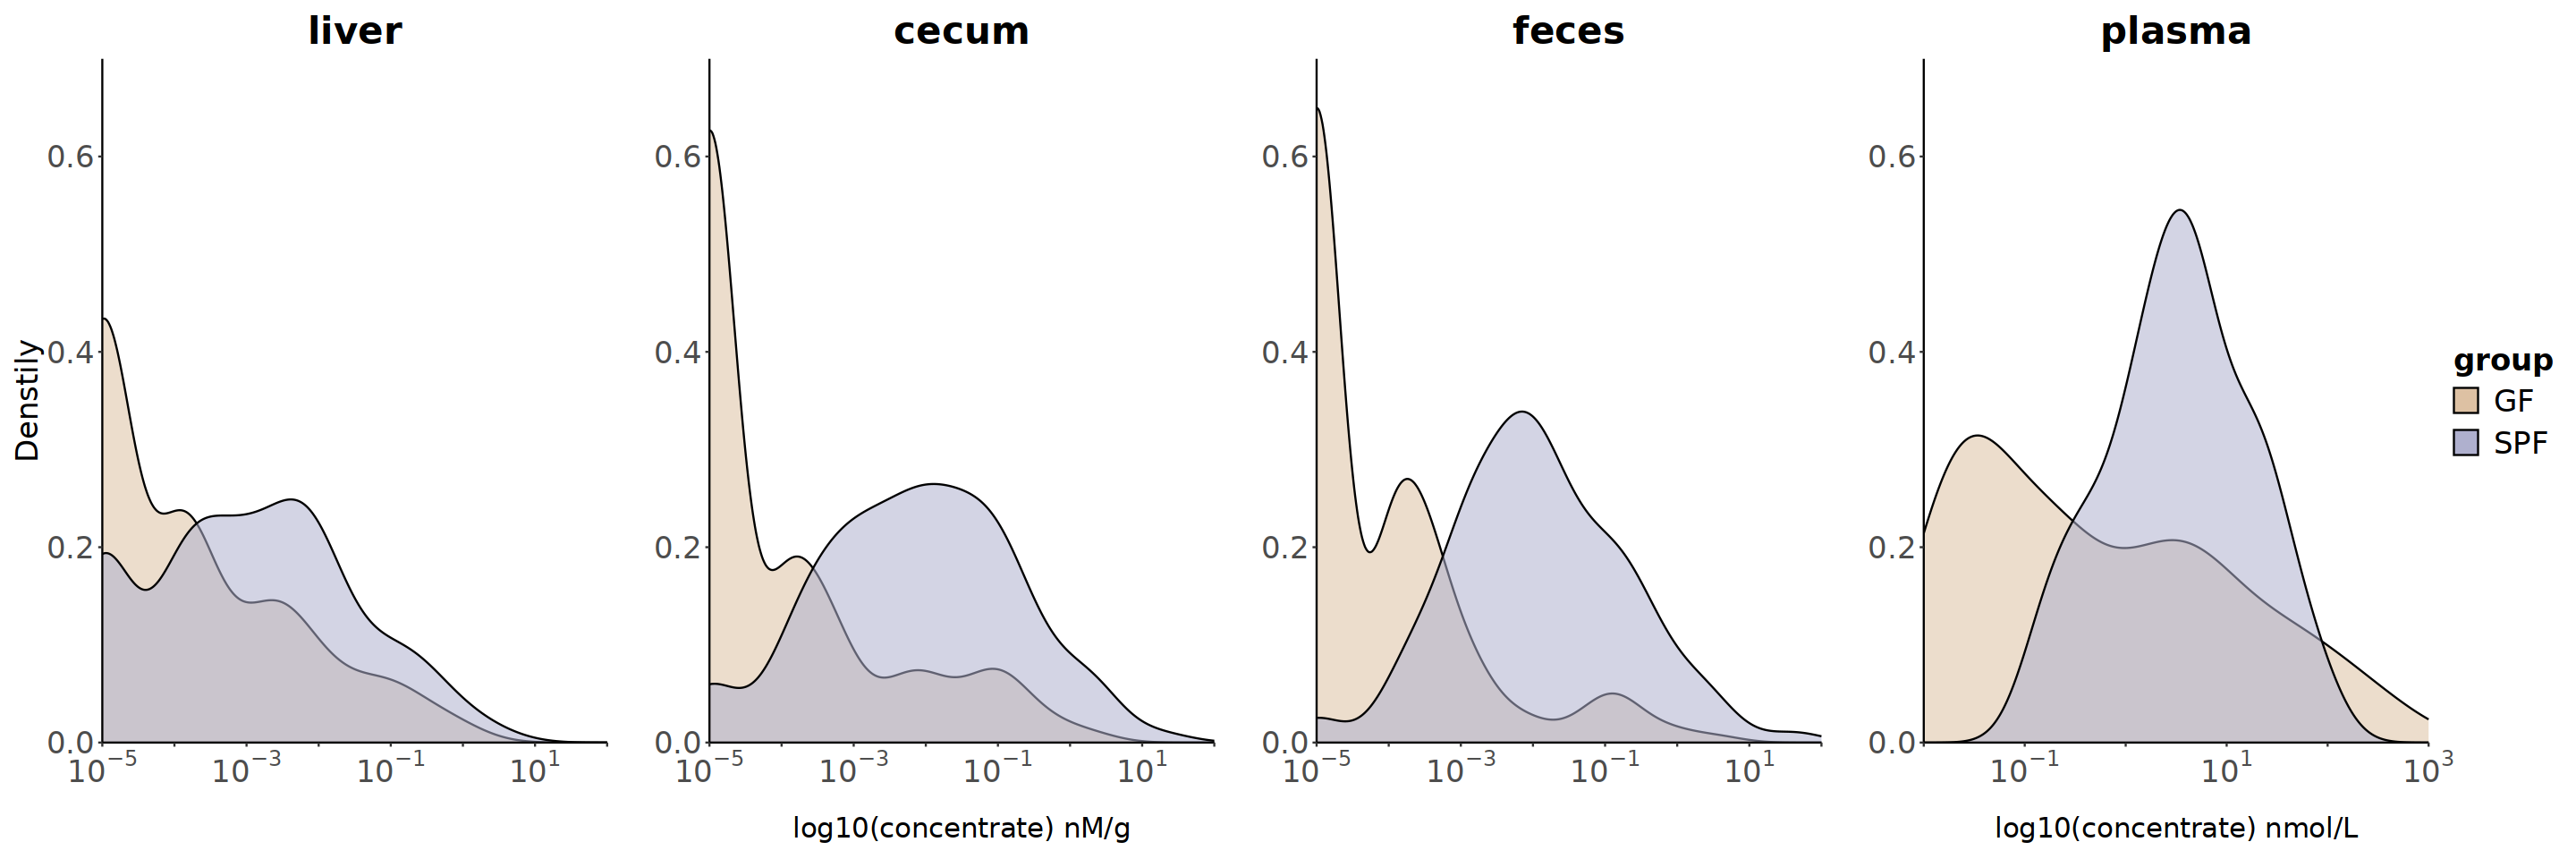

In [25]:
h1$cecum <- h1$cecum + labs(caption="log10(concentrate) nM/g") +
  theme(plot.caption=element_text(size=18, hjust=0.5, margin=margin(0,0,0,0)))
h1$liver <-  h1$liver + theme(legend.position = "none") + labs(y = "Denstily")
h1$plasma <- h2$plasma + labs(caption="log10(concentrate) nmol/L") +
  theme(plot.caption=element_text(size=18, hjust=0.5, margin=margin(0,0,0,0)))
options(repr.plot.width = 24,repr.plot.height = 8)
p <- wrap_plots(h1,ncol=4,guides = "collect")
p

In [26]:
pdf("Figure_6A.pdf",w = 24,h = 8)
print(p)
dev.off()

png 
  2

##  Figure 6B

In [44]:
CaluLinkList <- function(lst,sort_Abbreviation){
    dat_lst <- list()
    for(i in names(lst)){
        #print(i)
        data <- lst[[i]]
        dat_lst[[i]]$counts <- data
        colnames(data)[2] <- "Group_type"
        dat <- data %>% select(Group_type,Abbreviation, value)
        dat <- spread(dat,key = Group_type,value = value)
        dat$Tissue <- i
        dat$Abbreviation <- as.character(dat$Abbreviation)
        #print(head(dat,2))
        dat_lst[[i]]$link <- dat  %>% mutate(Abbreviation = fct_relevel(Abbreviation,sort_Abbreviation)) %>%
                    arrange(by=desc(Abbreviation)) %>%
                        mutate(GroupA=cumsum(.data[[colnames(dat)[2]]]), 
                               GroupB=cumsum(.data[[colnames(dat)[3]]]))
        #print('--end--')
    }
    return(dat_lst)
}
WrapPlot <- function(lst,mycolor,ncol,ax.tx.size = 20,
                     lg.tx.size = 16,
                     lg.tl.size = 25){
    # theme self # 
    mytheme <- theme_classic() + theme(
        axis.text.y = element_text(size = ax.tx.size,face = "bold",margin = margin(0,5,0,0)),
        axis.text.x = element_text(size = ax.tx.size,face = "bold",margin = margin(5,0,0,0)),
        axis.line = element_line(linetype = 1,color= "black",size = 1),
        axis.ticks = element_line(linetype = 1,color= "black",size = 1,lineend = 100),
        legend.text = element_text(size = lg.tx.size,face = "bold"),
        legend.title = element_text(size = lg.tl.size,face = "bold")) + 
               theme(legend.key.size = unit(1,"cm"), 
                  legend.spacing.x = unit(0.2,'cm'),
                  legend.spacing.y = unit(0.2,'cm'),
                  legend.text = element_text(margin = margin(t = 0,r = 0,b = 0,l =  0))) + 
               theme(plot.title = element_text(size = 25,hjust = 0.5,face = "bold"),plot.margin = margin(0,0,0,0))
    plst <- lst()
    for(i in names(lst)){
        counts <- lst[[i]]$counts
        print(head(counts,2))
        links <- lst[[i]]$link
        print(head(links,2))
        counts$Abbreviation <- factor(counts$Abbreviation,levels = levels(links$Abbreviation))
        str(counts)
        plst[[i]] <-  ggplot(counts, aes(x=Group, y=value, fill=Abbreviation)) +
                geom_bar(stat = "identity", width=0.5, col='black',alpha = 0.5)  +
                geom_segment(data=links, aes(x=1.25, xend=1.75, y=GroupA, yend=GroupB)) +
                scale_fill_manual(values=mycolor) + xlab('') +
                ylab(" ") + labs(title = i) + 
        guides(fill = guide_legend(ncol = 2, byrow = TRUE,override.aes = list(size = 10)))+ mytheme  
    }
    p <- wrap_plots(plst,ncol= ncol,guides = "collect")
    return(p)
}
WrapflowPlot <- function(lst,mycolor,order,ncol,ax.tx.size = 20,
                     lg.tx.size = 16,
                     lg.tl.size = 25){
    # theme self # 
    mytheme <- theme_classic() + theme(
        axis.text.y = element_text(size = ax.tx.size,face = "bold",margin = margin(0,5,0,0)),
        axis.text.x = element_text(size = ax.tx.size,face = "bold",margin = margin(5,0,0,0)),
        axis.line = element_line(linetype = 1,color= "black",size = 1),
        axis.ticks = element_line(linetype = 1,color= "black",size = 1,lineend = 100),
        legend.text = element_text(size = lg.tx.size,face = "bold"),
        legend.title = element_text(size = lg.tl.size,face = "bold")) + 
               theme(legend.key.size = unit(1,"cm"), 
                  legend.spacing.x = unit(0.2,'cm'),
                  legend.spacing.y = unit(0.2,'cm'),
                  legend.text = element_text(margin = margin(t = 0,r = 0,b = 0,l =  0))) + 
               theme(plot.title = element_text(size = 25,hjust = 0.5,face = "bold"),plot.margin = margin(0,0,0,0))
    plst <- lst()
    for(i in names(lst)){
        counts <- lst[[i]]
        counts$Abbreviation <- factor(counts$Abbreviation,levels = order)
        #str(counts)
        plst[[i]] <-  ggplot(counts, aes(x = Group, y = value, fill = Abbreviation,
                                      stratum = Abbreviation, alluvium = Abbreviation )) +
                geom_col(width = 0.5,color= "black") + 
                geom_flow(width = 0.5,alpha = 0.4, knot.pos=0.5) + theme_classic()  +
                scale_fill_manual(values=mycolor) + xlab('') +
                ylab(" ") + labs(title = i) + 
        guides(fill = guide_legend(ncol = 2, byrow = TRUE,override.aes = list(size = 10)))+ mytheme  
    }
    p <- wrap_plots(plst,ncol= ncol,guides = "collect")
    return(p)
}
date()


[1] "Sun Jan 12 22:13:00 2025"

In [38]:
dat_lst <- readRDS("Figure_6B_composition.rds")
date()

[1] "Sun Jan 12 22:11:32 2025"

In [39]:
sort_abb <- c("CA","beta_CA","NorCA","APCA","CDCA","a_MCA","beta_MCA","w_MCA","HCA","UCA","UDCA","beta_UDCA",
              "TCA","TCDCA","T_a_MCA","T_beta_MCA","T_w_MCA","GHCA","GUDCA","TUDCA","MDCA","NorDCA",
              "DCA","beta_DCA","three_oxoCA","LCA","Dio_LCA","Iso_ACA","HDCA","beta_HDCA","TDCA","TLCA",
              "THDOCA","seven_KetoLCA","seven_KetoDCA","twelve_ketoLCA")
BA_color<-c("CA"="#C775EF","beta_CA"="#C7DEAC",
            "NorCA"="#D8F2A3","APCA"="#3C9DB5",
            "CDCA"="#DD8BCC","a_MCA"="#C3E677",
            "beta_MCA"="#F2896F","w_MCA"="#E46166",
            "HCA"="#E5F38B","UCA"="#E2EAB8",
            "UDCA"="#81D0D4","beta_UDCA"="#EEA507",
            "TCA"="#FDE4CC","TCDCA"="#4DEAE4",
            "T_a_MCA"="#D9E1E1","T_beta_MCA"="#F4F8A7",
            "T_w_MCA"="#B666FB","GHCA"="#CBDAFA",
            "GUDCA"="#8BFB7A","TUDCA"="#F46F6F",
            "MDCA"="#FC678A","NorDCA"="#CBBAC0",
            "DCA"="#F2F39C","beta_DCA"="#14AFAF",
            "three_oxoCA"="#F8A477","LCA"="#DEDB9F",
            "Dio_LCA"="#FEE5B8","Iso_ACA"="#2EA5C2"
            ,"HDCA"="#E4E0DC","beta_HDCA"="#F1C309",
            "TDCA"="#2C958F","TLCA"="#EF4842",
            "THDOCA"="#B3F8D0","seven_KetoLCA"="#F0CBD2",
            "seven_KetoDCA"="#D57F96","twelve_ketoLCA"="#B96069")

In [45]:
datB <- CaluLinkList(lst = dat_lst,sort_Abbreviation = sort_abb)
p <- WrapflowPlot(lst = dat_lst,order = sort_abb,mycolor = BA_color,ncol =4)

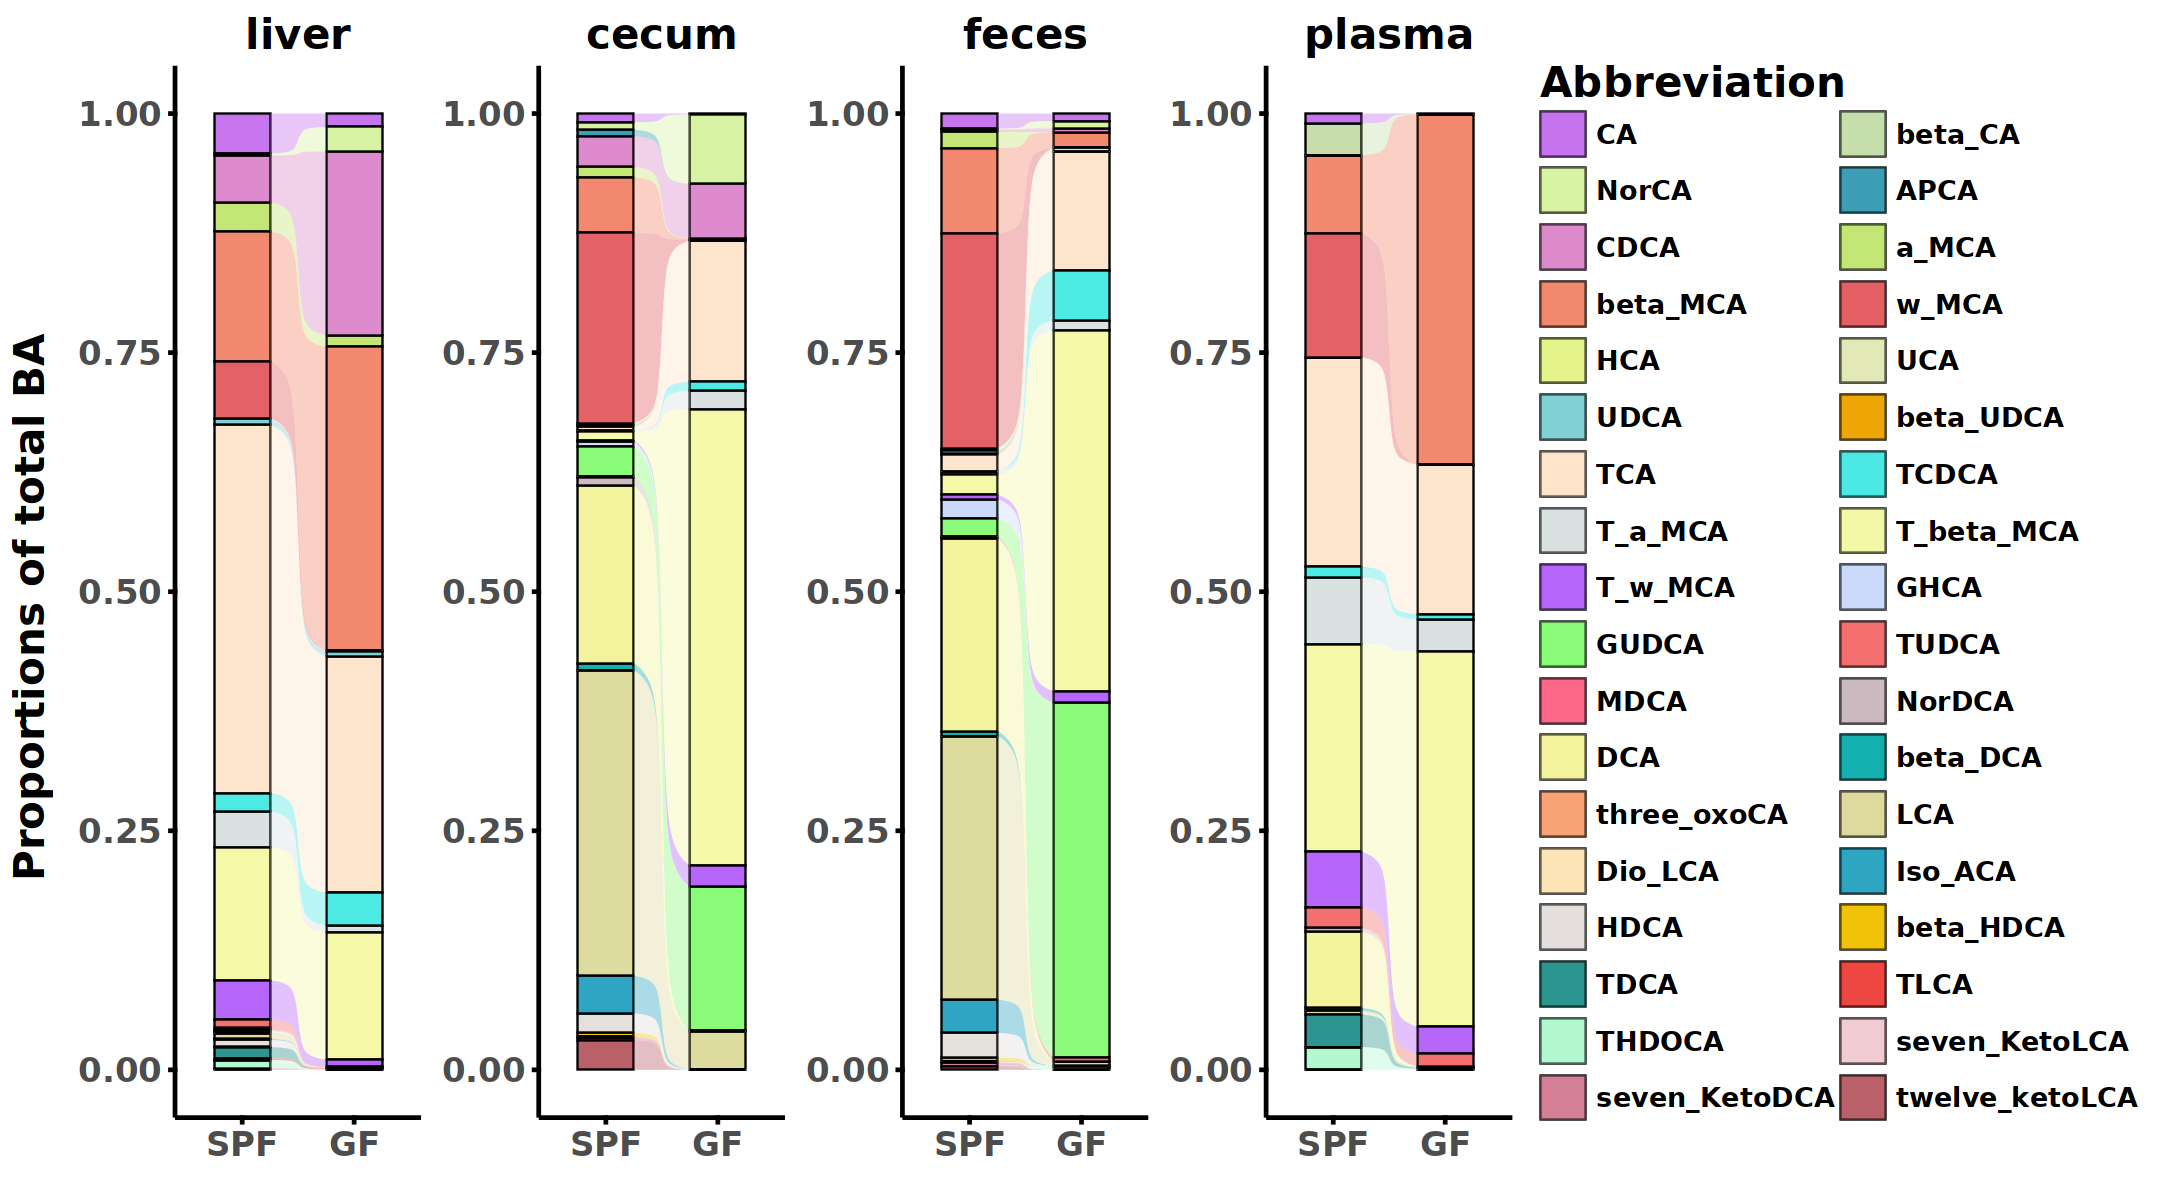

In [46]:
options(repr.plot.width =18,repr.plot.height = 10)
p <- wrap_elements(panel = p)  + labs(tag = "Proportions of total BA ") +
            theme(plot.tag = element_text(size = 25,angle = 90,margin = margin(0,0,0,0),face = "bold"),
                                                            plot.tag.position = "left")
p

In [47]:
pdf("Figure_6B.pdf",w = 18,h = 10)
print(p)
dev.off()

png 
  2

##  Figure 6C

In [54]:
mulitBarplot <- function(dat,color=c("#955117","#F3E295")){
    dat$Group<-factor(dat$Group,levels=c("SPF","GF"))
    dat$variable<-factor(dat$variable,levels=c("mean_non_OH","mean_OH"))
    theme_self <- theme(plot.title = element_text(size = 25,hjust = 0.5,face = "bold"),
                        axis.text = element_text(size = 16),
                        #axis.title = element_text(size = 23),
                        legend.text = element_text(size = 16),
                        legend.title = element_text(size = 18 ,face = "bold"),
                        axis.title.y = element_text(size=18,margin = margin(0,10,0,0))) + 
                  theme(strip.background = element_blank(),strip.text =  element_text(size = 23,angle = 0))
    p <-ggplot(dat,aes(x=Group,y=Relative_Abundance,fill=variable))+ facet_wrap(~Type,ncol = 4) +
                  geom_bar(stat="identity",width = 0.7)+theme_classic()+
                  scale_fill_manual(values=color,labels = c("non 12-OH","12-OH"))+
                  labs(title = "", x = "", y = "Realtive Abundance")  + theme_self  +
                    guides(fill = guide_legend(title = "BA type",ncol = 1, byrow = TRUE))
    return(p)
}

In [53]:
data <- readRDS("Figure_6C_OH_nonOH.rds")
group_liver_cecum_feces_mean1_RA1 <- data[["liver"]]
group_plasma1t_OH_sum1t1_mean1_RA1 <- data[["plasma"]]
dat <- do.call(rbind,data)
date()

[1] "Sun Jan 12 22:14:16 2025"

[1] "Sun Jan 12 22:14:19 2025"

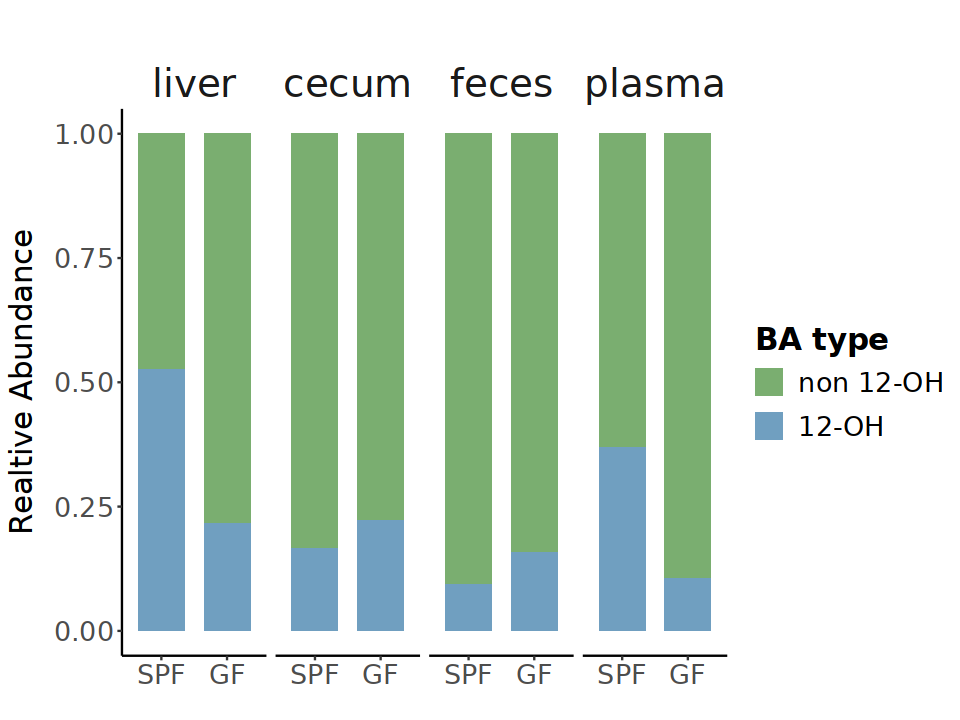

In [55]:
options(repr.plot.width = 8,repr.plot.height = 6)
p <- mulitBarplot(dat = dat,color = c("#7aae70","#709fc0"))
p
date()

In [57]:
pdf("Figure_6C.pdf",w = 8,h = 6)
print(p)
dev.off()

png 
  2

##  Figure 6D

In [59]:
DoBoxplot <- function(data,x = "Group.x",y = "CDCA_CA" , color = c("#FF0000","#0000FF"),title){
    data$Group.x<-factor(data$Group.x, levels=c("GF","SPF"))
    theme_self <- theme(plot.title = element_text(size = 23,hjust = 0.5,face = "bold"),
                        axis.text = element_text(size = 15,colour="#000000"),
                        axis.title = element_text(size = 18,colour="#000000"),
                        legend.text = element_text(size = 15),
                      legend.title = element_text(size = 18 ,face = "bold"))
    p <- ggplot(data=data,aes_string(x = x,y = y))+
              geom_boxplot(aes(fill=Group.x),outlier.colour=NA,width=0.4,position="dodge",alpha=1)+
              scale_fill_manual(values=color,labels=c('GF','SPF'))+
              scale_x_discrete(limits = c("SPF","GF")) + 
              theme_classic()+labs(x="",y="",title =title)+
              geom_jitter(position=position_jitter(0.08))+
              geom_signif(comparisons=list(c('SPF',"GF")),
              test=wilcox.test,step_increase=0.1,textsize=5,
              map_signif_level=T, colour="#000000") + theme_self + guides(fill = guide_legend(title = "Group"))
    return(p)

}
date()

[1] "Sun Jan 12 22:15:39 2025"

In [60]:
data <- readRDS("liver_45Bile.rds")
date()

[1] "Sun Jan 12 22:15:40 2025"

In [68]:
liver_CDCA_CA <- data[["liver_CDCA_CA"]]
p1 <- DoBoxplot(data = liver_CDCA_CA,y = "CDCA_CA",title = "CDCA/CA",
               color = c("#ddc1a3","#afb0ce"))

liver_beta_MCA_CA <- data[["liver_beta_MCA_CA"]]
p2 <- DoBoxplot(data = liver_beta_MCA_CA,y = "beta_MCA_CA",title = "beta-MCA/CA",
               color = c("#ddc1a3","#afb0ce"))

# merge # 
plist <- list(p1 = p1,p2 = p2)
p <- wrap_plots(plist,ncol=2,guides = "collect") 
p <- wrap_elements(panel = p)  + labs(tag = "Radio") +theme(plot.tag = element_text(size = 18,angle = 90,
                                                                                    margin = margin(0,-20,0,0)),
                                                            plot.tag.position = "left") +
               plot_annotation(caption = "Liver",theme = theme(plot.caption = element_text(size = 20,hjust = 0.45,
                                                                      margin = margin(-20,0,0,0))))

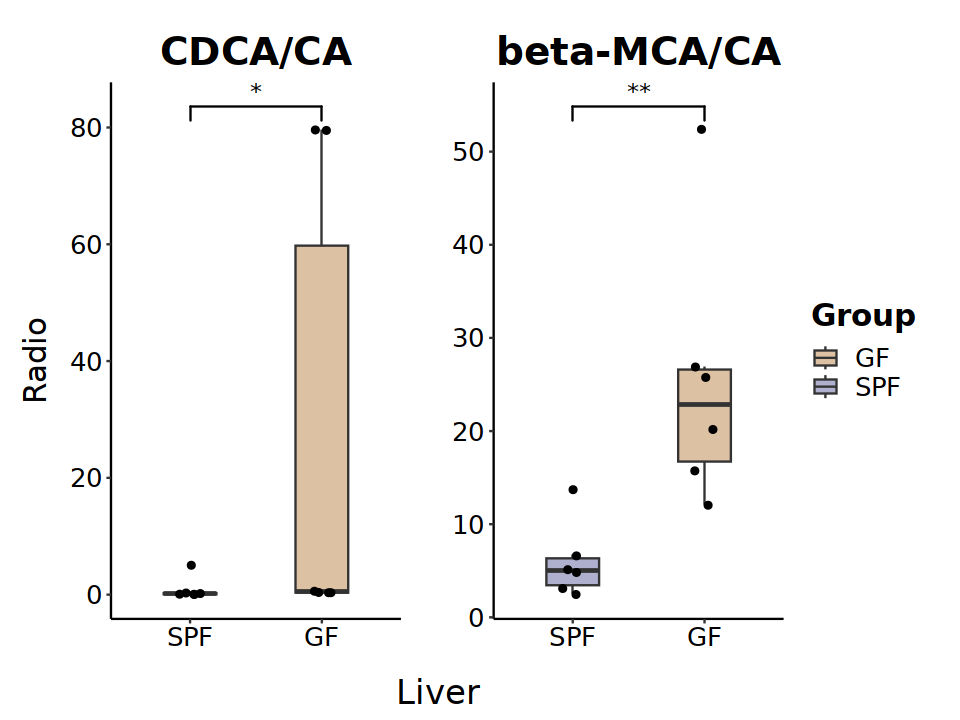

In [69]:
options(repr.plot.width = 8,repr.plot.height = 6)
p

In [70]:
pdf("Figure_6D.pdf",w = 8,h = 6)
print(p)
dev.off()

png 
  2

# Figure 6 E # python kernel

## Figure 6E # 

In [1]:
import datetime
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import sys 
warnings.filterwarnings('ignore')
datetime.datetime.now().strftime('%c')

'Tue Jan 14 18:11:44 2025'

In [2]:
from matplotlib.colors import LinearSegmentedColormap
mycolor = LinearSegmentedColormap.from_list("",["white","red"])

### liver ### 

In [7]:
liver = sc.read_h5ad("liver.h5ad")

In [8]:
input_file = "liver_function_genelist.txt"
Gene = pd.read_csv(input_file,sep = "\t")# ,header = None
NoFound = []
marker = Gene["Gene"].to_list()
for i in NoFound :
    print(i)
    marker.remove(i)
    
g0 = Gene[Gene['Class'] == 'BA synthesis']
g1 = Gene[Gene['Class'] == 'BA transporters']
g2 = Gene[Gene['Class'] == 'regulates the synthesis']

FG1 = {'BA synthesis' : g0["Gene"].unique().tolist(),
       'BA transporters' : g1["Gene"].unique().tolist(),
       'regulates the synthesis' : g2["Gene"].unique().tolist(),}
datetime.datetime.now().strftime('%c')

'Tue Jan 14 18:14:03 2025'

In [11]:
sort=['GF_Hepatocytes-Portal','GF_Hepatocytes-Mid','GF_Hepatocytes-Central',
      'SPF_Hepatocytes-Portal','SPF_Hepatocytes-Mid','SPF_Hepatocytes-Central']
liver.obs['celltypes'].cat.reorder_categories(sort,inplace=True)

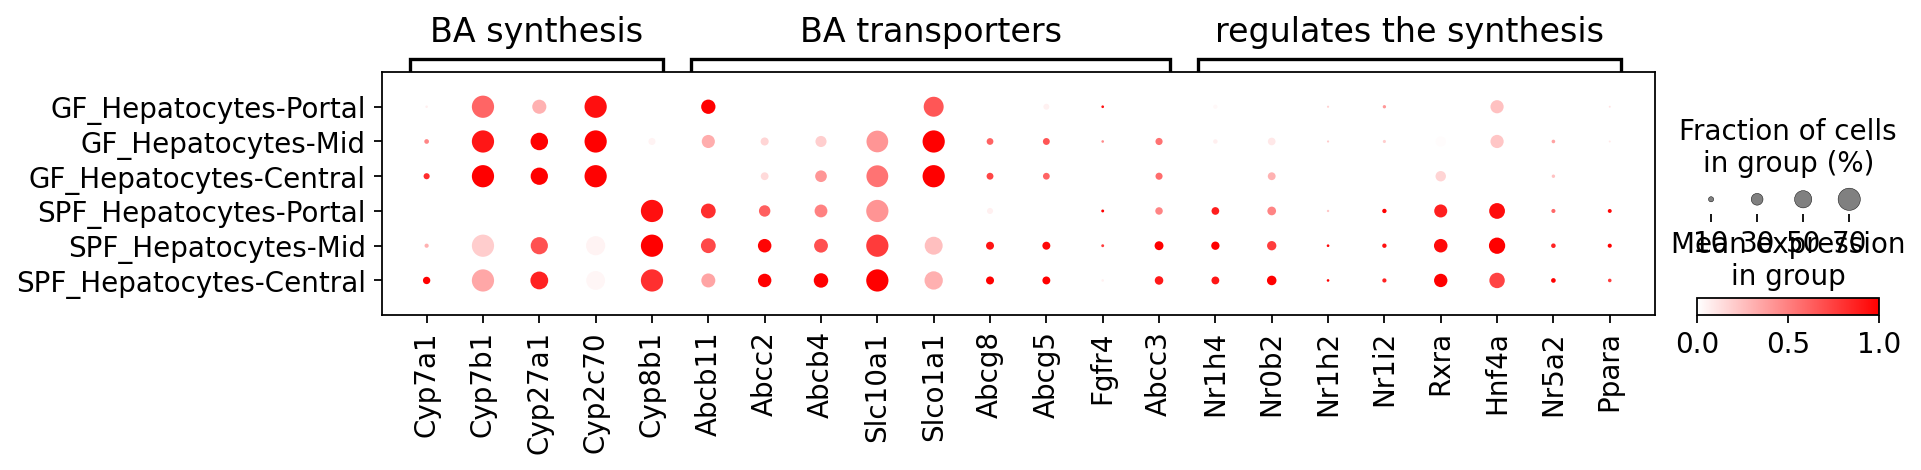

In [12]:
%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42
sc.set_figure_params(scanpy=True, fontsize=15)
fig = sc.pl.dotplot(liver, FG1, groupby="celltypes", standard_scale = "var", var_group_rotation=0 ,
                    use_raw = False, 
               linewidth=0, show =True, figsize=(12, 2), return_fig=True)
fig.style(largest_dot=100, cmap=mycolor,dot_max = 0.7)
fig.show()

In [ ]:
file ="./Figure_6E_liver_function_Dotplot.pdf"
fig.savefig(file,dpi = 1024)

### EP ### 

In [14]:
EP = sc.read_h5ad("intestines_EP.h5ad")
datetime.datetime.now().strftime('%c')

'Tue Jan 14 18:14:37 2025'

In [15]:
input_file = "EP_function_genelist.txt"
Gene = pd.read_csv(input_file,sep = "\t")# ,header = None
NoFound = []
marker = Gene["Gene"].to_list()
for i in NoFound :
    print(i)
    marker.remove(i)
g0 = Gene[Gene['Class'] == 'Regulation/Transporter gene']
FG1 = {'Regulation/Transporter gene' : g0["Gene"].unique().tolist()}

In [18]:
sort=["GF_cecum","SPF_cecum","GF_colon","SPF_colon","GF_ileum","SPF_ileum"]
EP.obs['group'].cat.reorder_categories(sort,inplace=True)

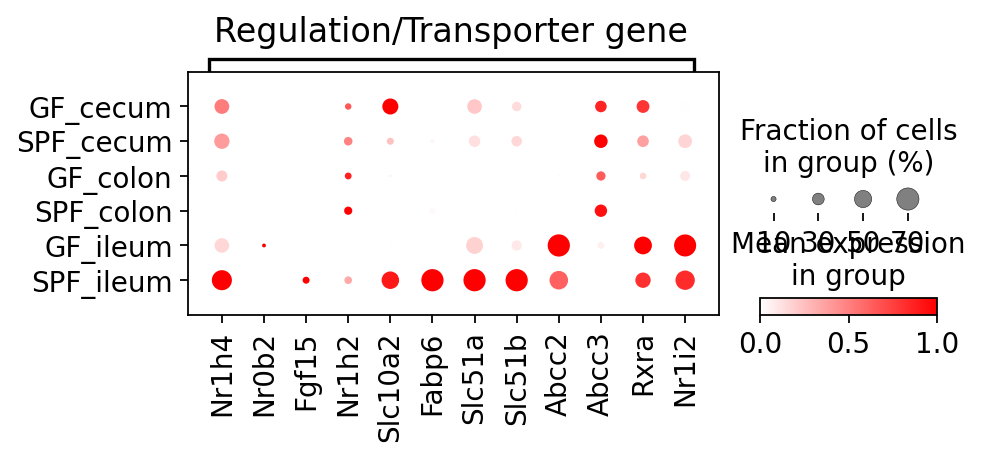

In [19]:
%matplotlib inline
#sc.set_figure_params(scanpy=True)
sc.set_figure_params(scanpy=True, fontsize=15)
mpl.rcParams['pdf.fonttype'] = 42
fig = sc.pl.dotplot(EP, FG1, groupby="group", standard_scale = "var", var_group_rotation=0 ,
                    use_raw = False,  
                    # size_exponent=5,
               linewidth=0, show =True, figsize=(6,2), return_fig=True) # cmap = mycolor,dot_max = 0.7,
fig.style(largest_dot=100, cmap=mycolor,dot_max = 0.7)
fig.show()

In [ ]:
file ="./Figure_6E_intestine_function_Dotplot.pdf"
fig.savefig(file,dpi = 1024)